<a href="https://colab.research.google.com/github/codeboy5/probml-notebooks/blob/update-score-matching-demo/notebooks/score_matching_swiss_roll.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Fit score-based  generative model to 2d swiss roll data.

Code is taken from
https://jax.readthedocs.io/en/latest/notebooks/score_matching.html

Notebook author: Denis Mazur, edited by Just Heuristic, updated by [Saksham Rastogi](https://github.com/codeboy5)


In [16]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import make_swiss_roll


import jax
import jax.numpy as jnp

try:
    from flax import linen as nn  # The Linen API
except ModuleNotFoundError:
    #%pip install -qq flax
    from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    #%pip install -qq optax
    import optax  # Optimizers

from functools import partial

from IPython.display import clear_output

# Dataset

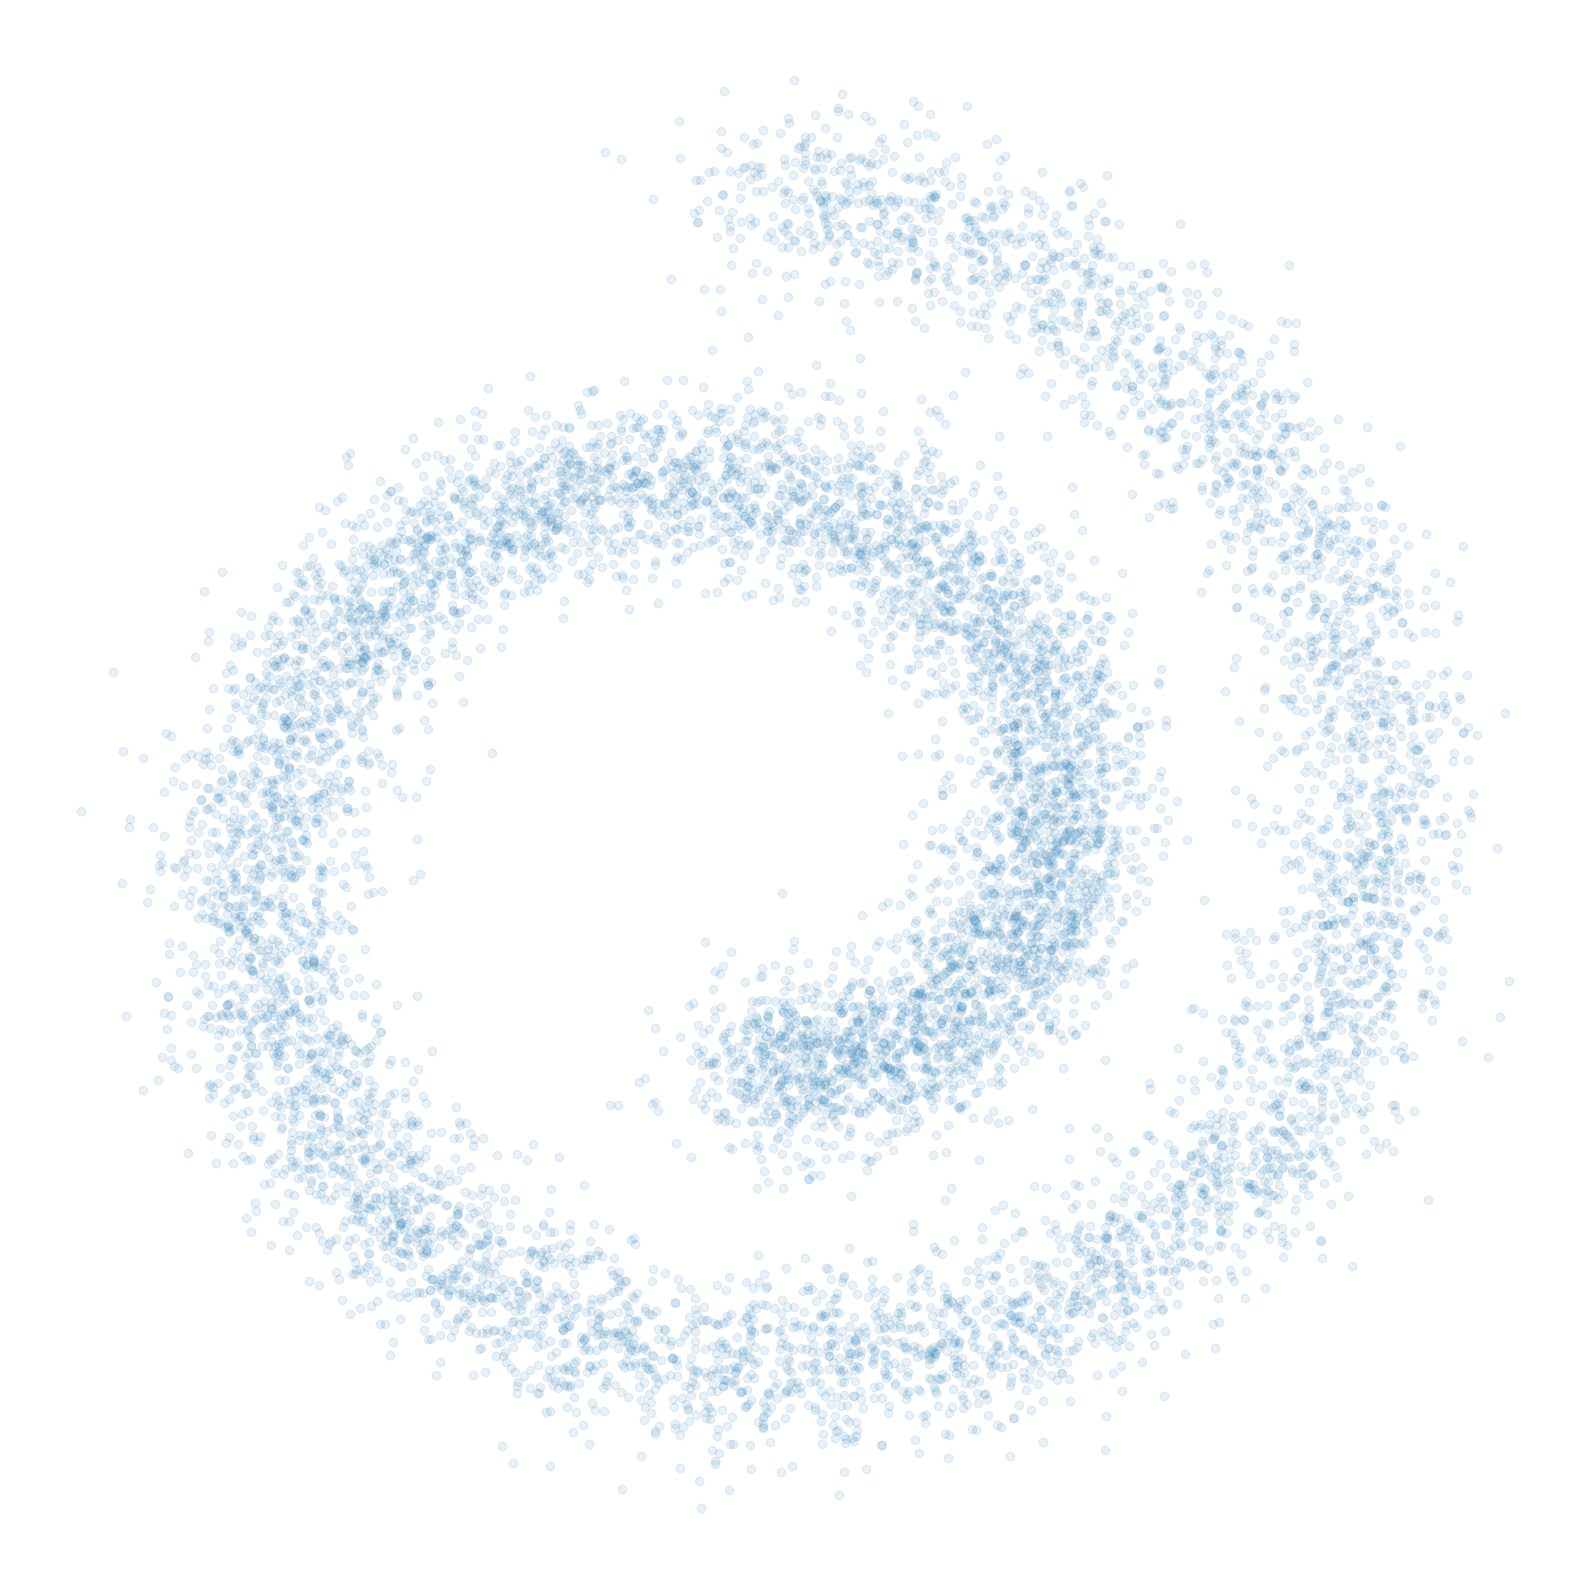

In [17]:
def sample_batch(size, noise=1.0):
    x, _ = make_swiss_roll(size, noise=noise)
    x = x[:, [0, 2]] / 10.0
    return np.array(x)


plt.figure(figsize=[16, 16])
plt.scatter(*sample_batch(10**4).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("swiss_roll.png")

In [18]:
import pprint


# Fit score function

In [19]:
class Model(nn.Module):
    @nn.compact
    def __call__(self, x):

        x = nn.Dense(128)(x)
        x = nn.softplus(x)
        x = nn.Dense(128)(x)
        x = nn.softplus(x)
        x = nn.Dense(2)(x)

        return x

In [20]:
@jax.jit
def compute_loss(params, inputs):
    #  a function that computes jacobian by forward mode differentiation
    jacobian = jax.jacfwd(Model().apply, argnums=-1)	#-1 deotes the last positional argument of .apply, apply has two positional arg (variables,x), so the jacobian is only taken wrt to x, but it still needs to be evaluated at (variables,x), so in the next line, need partial( ,{params}) to fixes variables=params; note jax.jacfwd returns a function, the jacobian J=∂[x=x₀,f], jacfwd( ) is a function of x₀, and returns the matrix J;

    # we use jax.vmap to vectorize jacobian function along batch dimension
    batch_jacobian = jax.vmap(partial(jacobian, {"params": params}))(inputs)  # [batch, dim, dim] variables=params, x=input; LHS=batched (∂model(variables,x)/∂x) evaluated at (params,input), LHS is square dim×dim, dim=dim(x) as ∂variables/∂x=0 so not included;

    trace_jacobian = jnp.trace(batch_jacobian, axis1=1, axis2=2)
    output_norm_sq = jnp.square(Model().apply({"params": params}, inputs)).sum(axis=1) 

    return jnp.mean(trace_jacobian + 1 / 2 * output_norm_sq)	# Murphy22Adv 24.30;

In [21]:
@jax.jit
def train_step(state, batch, key):
    """Train for a single step."""
    loss = compute_loss(state.params, batch)
    grads = jax.grad(compute_loss, argnums=0)(state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [22]:
def create_train_state(rng, learning_rate):
    """Creates initial `TrainState`."""
    net = Model()
    params = net.init(rng, jnp.ones([128, 2]))["params"]
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(apply_fn=net.apply, params=params, tx=tx)

In [23]:
def train_loop(key, train_step, nsteps):
    key, subkey = jax.random.split(key)
    state = create_train_state(subkey, 1e-3)
    del subkey  # Must not be used anymore.
    loss_history = []
    for i in range(nsteps):
        x = sample_batch(size=128)
        key, subkey = jax.random.split(key)
        state, loss = train_step(state, x, subkey)
        loss_history.append(loss.item())

        if i % 200 == 0:
            clear_output(True)
            plt.figure(figsize=[16, 8])
            plt.subplot(1, 2, 1)
            plt.title("mean loss = %.3f" % jnp.mean(jnp.array(loss_history[-32:])))
            plt.scatter(jnp.arange(len(loss_history)), loss_history)
            plt.grid()

            plt.subplot(1, 2, 2)
            xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 2.0, 50), jnp.linspace(-1.5, 2.0, 50)), axis=-1).reshape(
                -1, 2
            )
            scores = Model().apply({"params": state.params}, xx)
            scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
            scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)	#unit vector scaled by log(1+x);

            plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
            plt.xlim(-1.5, 2.0)
            plt.ylim(-1.5, 2.0)
            plt.show()

    return state

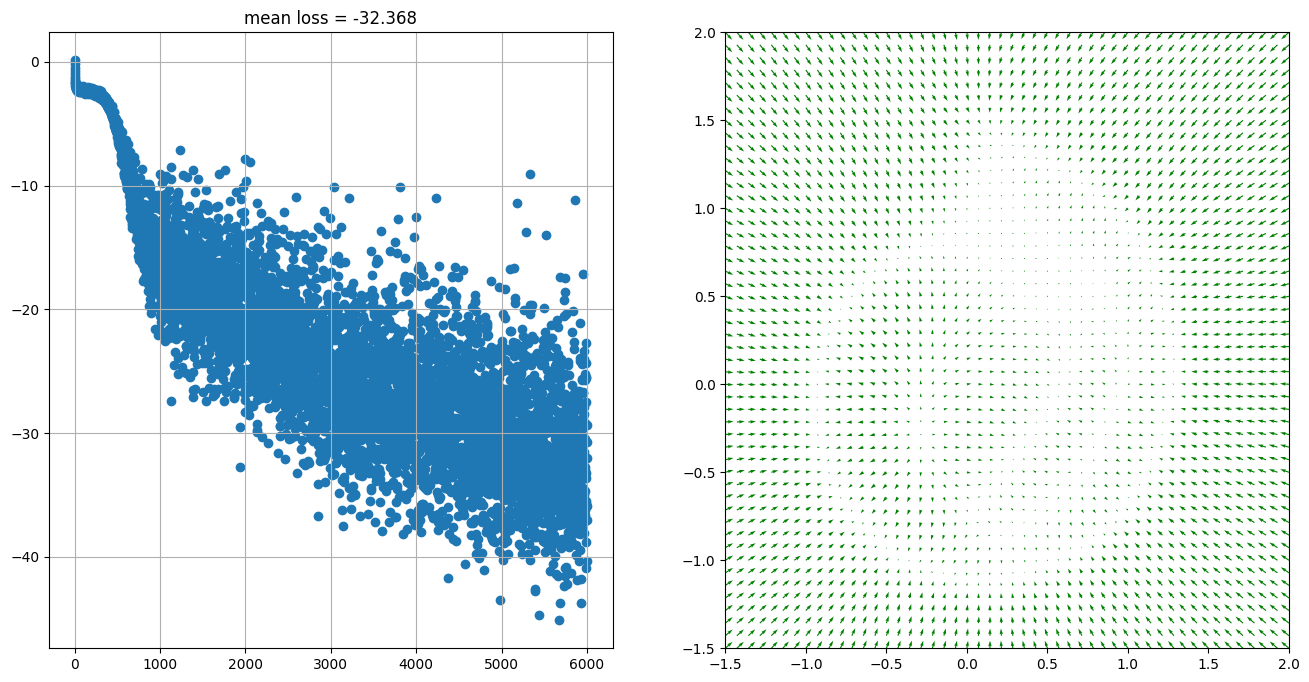

KeyboardInterrupt: 

In [24]:
state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)

In [ ]:
state_basic = state

# Plot gradient field

In [ ]:
state = state_basic

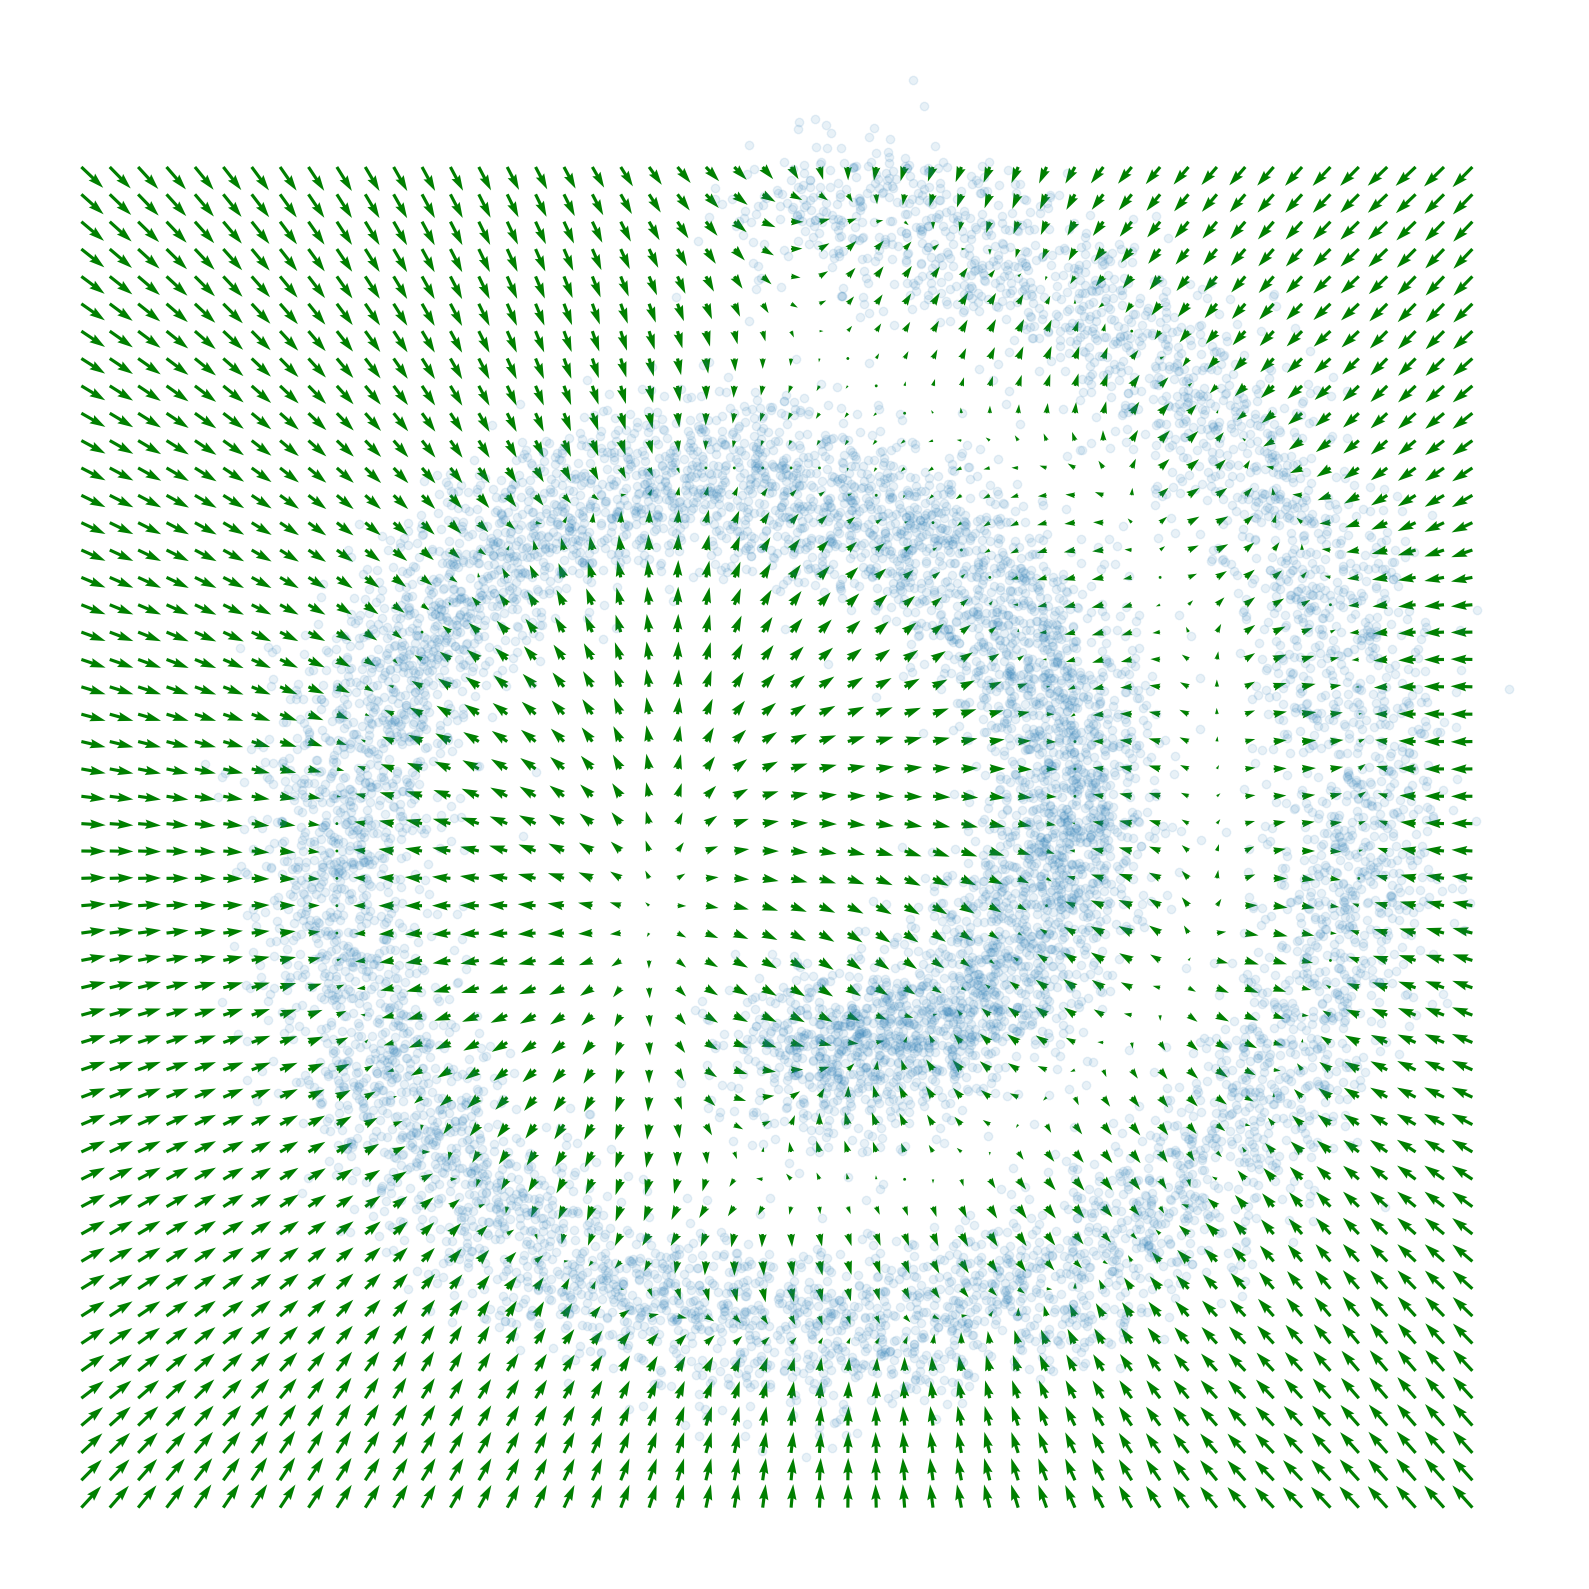

In [ ]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = Model().apply({"params": state.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_swiss_roll.png")

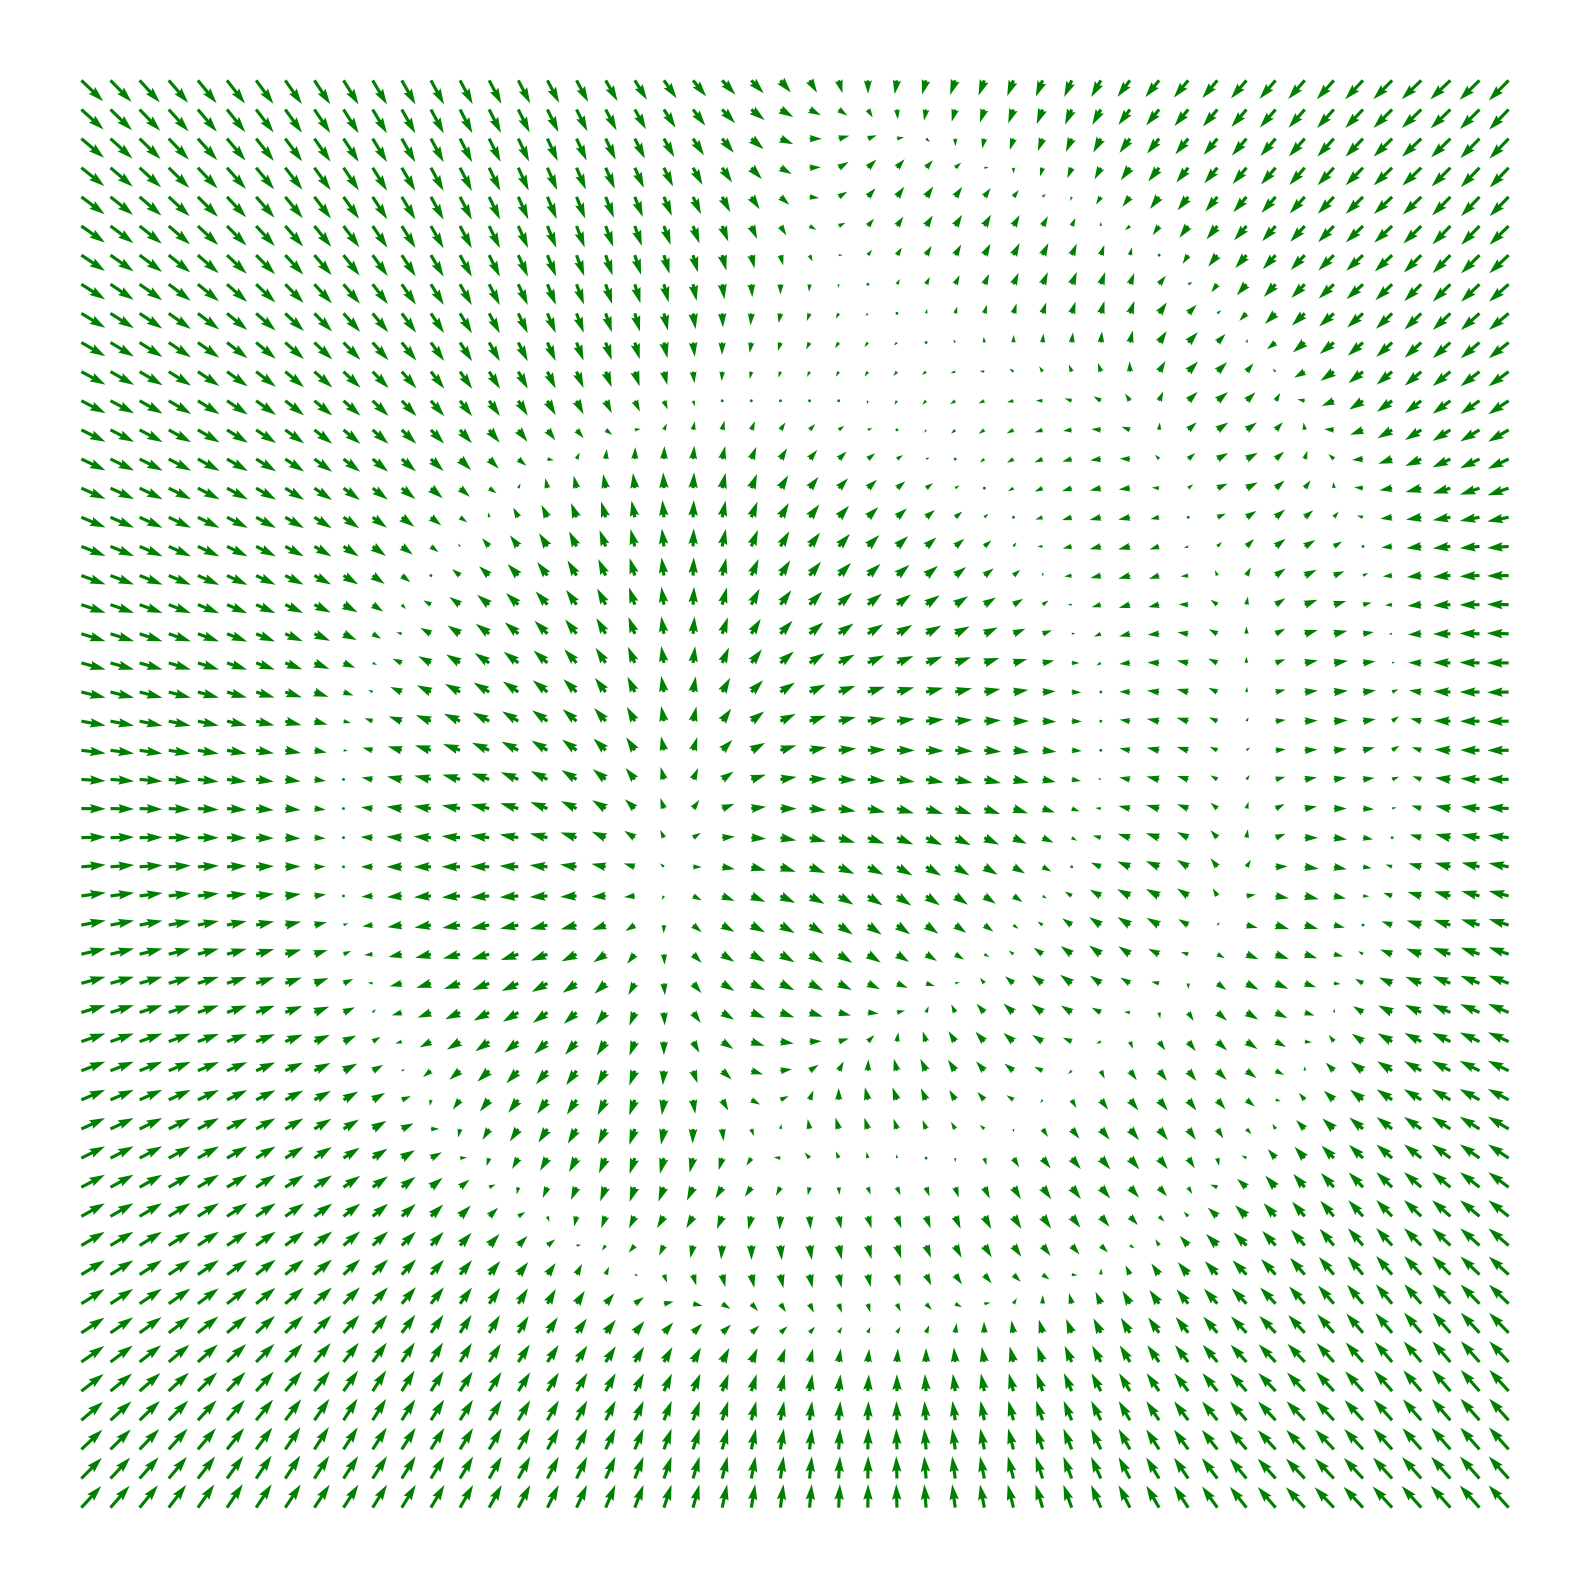

In [25]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = Model().apply({"params": state.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
# plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_swiss_roll_no_data.png")

# Fit using sliced score matching

In [ ]:
@jax.jit
def compute_ssm_loss(params, inputs, key):

    apply = jax.jit(partial(Model().apply, {"params": params}))
    batch_dot = partial(jnp.einsum, "bu,bu->b")

    # generate random vectors from N(0, I)
    v = jax.random.normal(key, shape=inputs.shape)

    # predict score and compute jacobian of score times v
    score, jac_v = jax.jvp(apply, [inputs], [v])

    return jnp.mean(batch_dot(v, jac_v) + 1 / 2 * batch_dot(v, score) ** 2)	#Murphy22Adv,24.42;

In [26]:
@jax.jit
def train_step(state, batch, key):
    """Train for a single step."""
    loss = compute_ssm_loss(state.params, batch, key)
    grads = jax.grad(compute_ssm_loss, argnums=0)(state.params, batch, key)
    state = state.apply_gradients(grads=grads)
    return state, loss

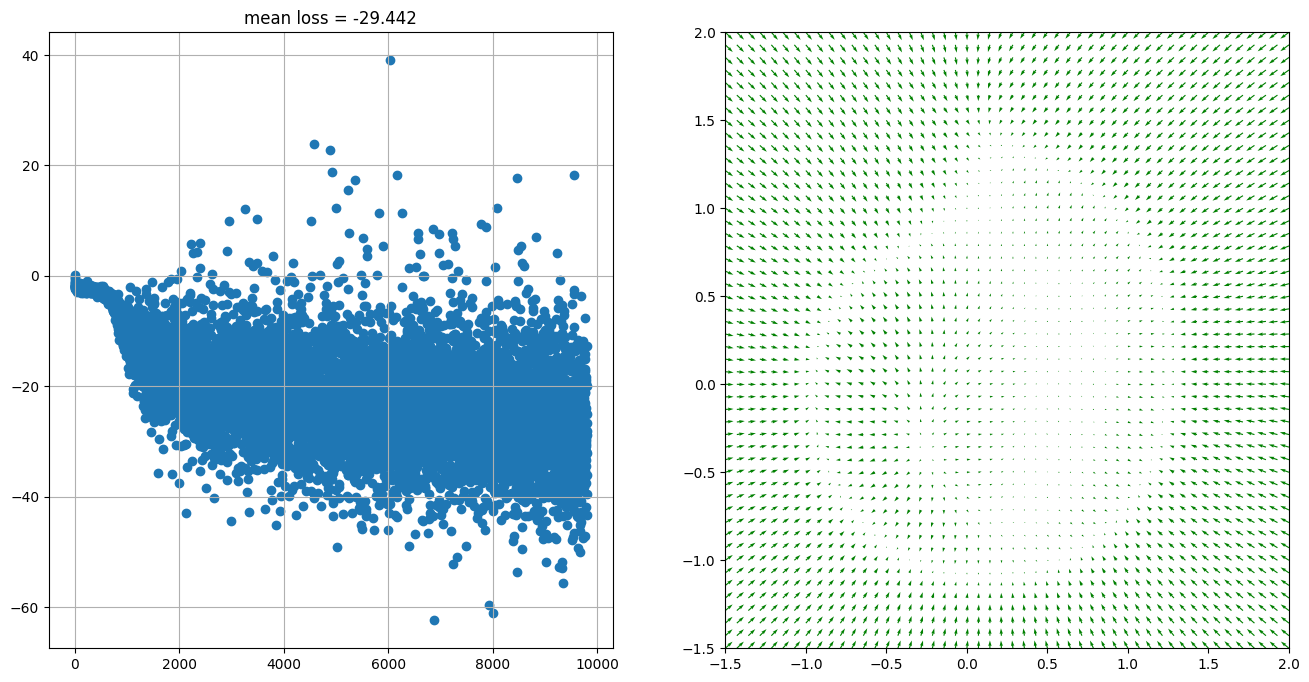

In [ ]:
state = train_loop(jax.random.PRNGKey(seed=42), train_step, 10000)
# compared to regular SM, sampling v~N( ) give occurances of occasional large losses

In [ ]:
state_basic = state

# Plot gradient field

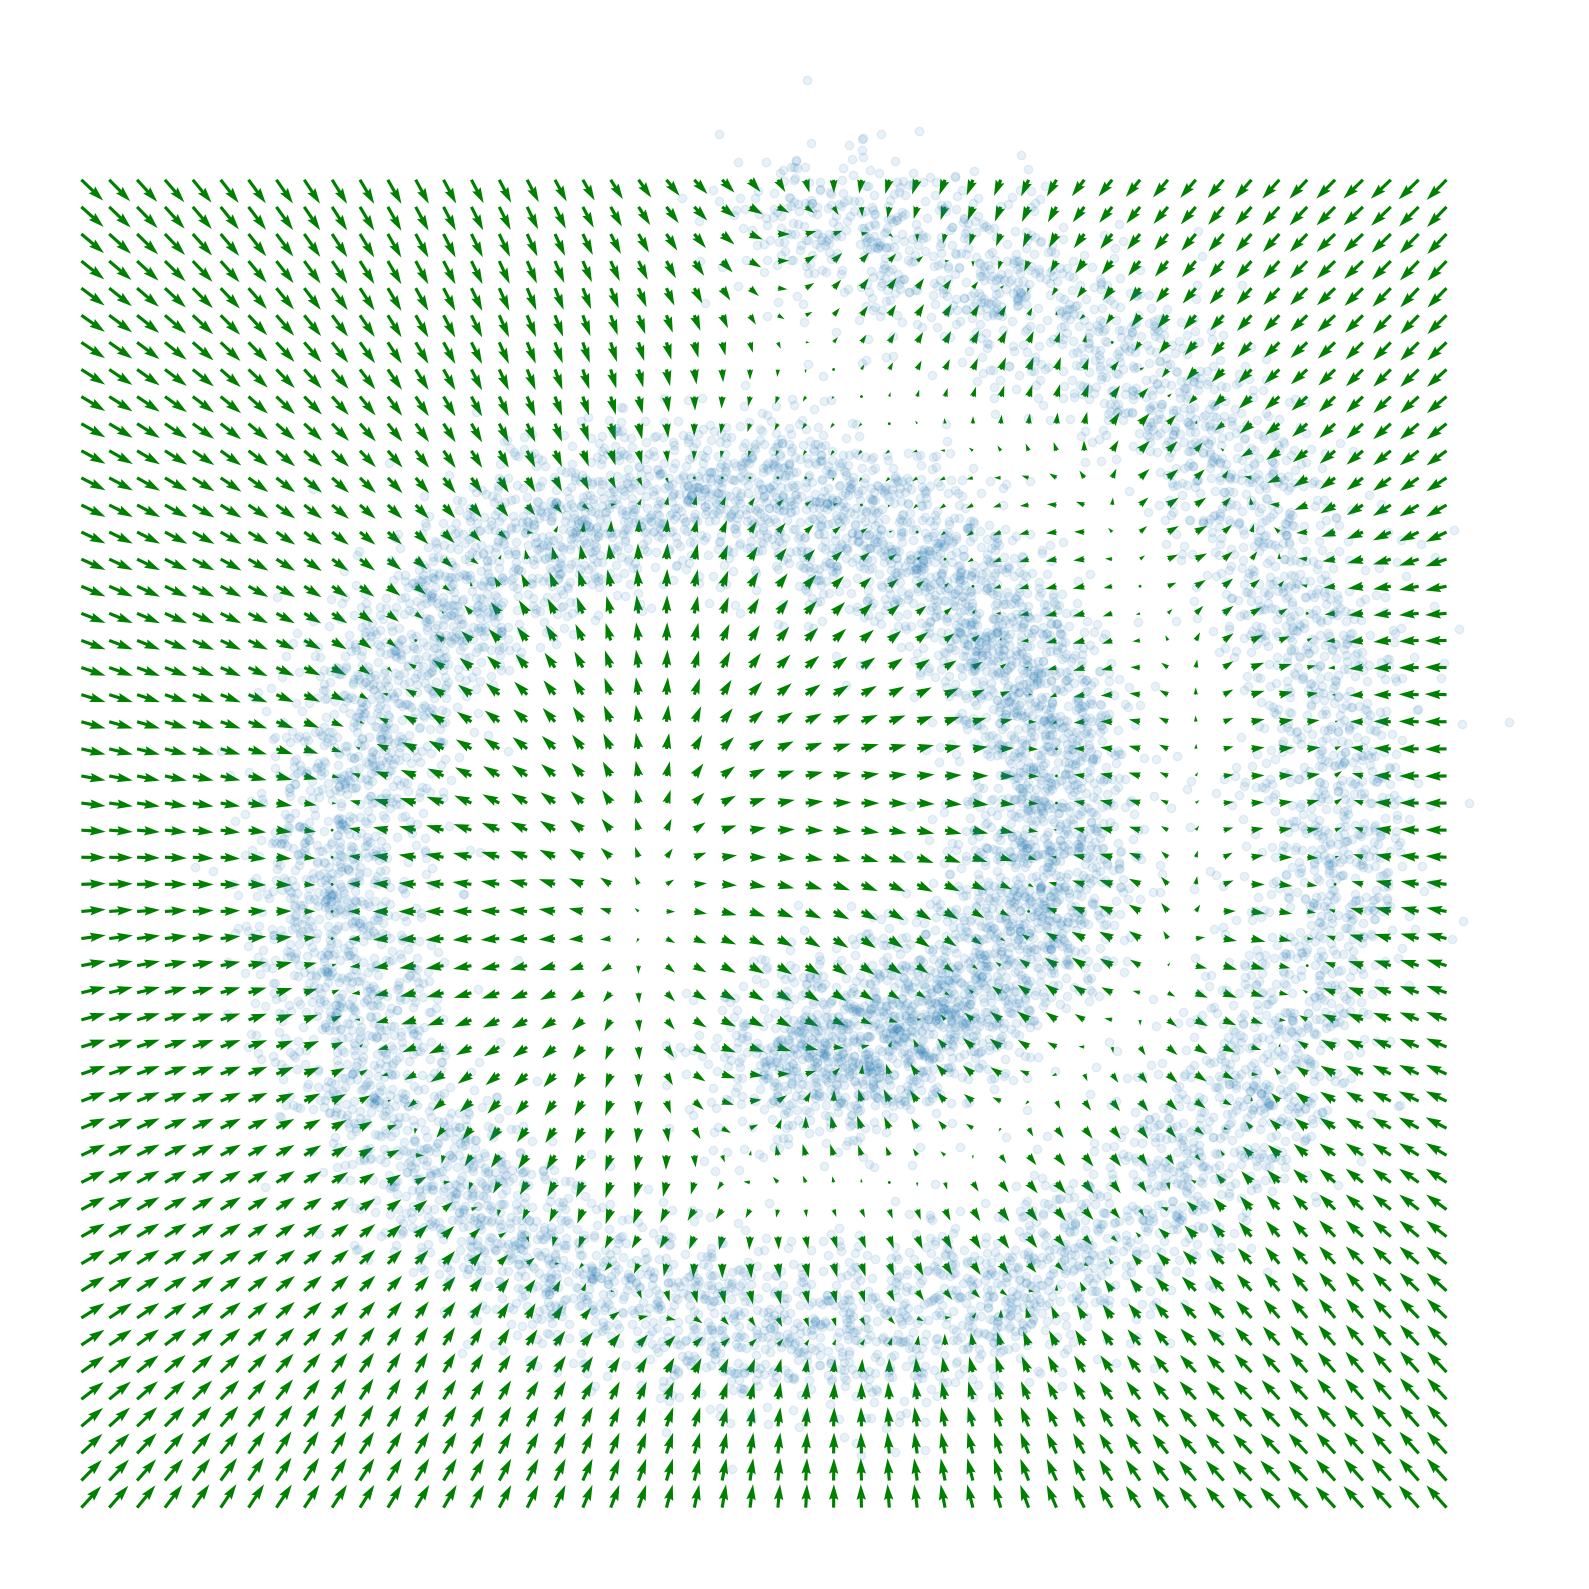

In [31]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = Model().apply({"params": state_basic.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.scatter(*sample_batch(10_000).T, alpha=0.1)
plt.axis("off")
plt.tight_layout()
plt.savefig("score_matching_sliced_swiss_roll.png", dpi=300)

In [ ]:
plt.figure(figsize=[16, 16])

xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = Model().apply({"params": state_basic.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)

plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
# plt.scatter(*sample_batch(10_000).T, alpha=0.1)

# Langevin sampling

In [32]:
def sample_langevin(x_initial, *, state, key, eps=1e-2, eps_decay=0.9, num_steps=15, temperature=1.0):
    """sample x ~ p(x) by applying approximate Langvenin Dynamics, return a sequence of x_t"""
    x_t, x_sequence = x_initial, [x_initial]

    for t in range(num_steps):
        key, subkey = jax.random.split(key)
        z_t = jax.random.normal(subkey, shape=x_t.shape)
        x_t = x_t + eps / 2 * Model().apply({"params": state.params}, x_t) + jnp.sqrt(eps) * temperature * z_t
        x_sequence.append(x_t)
        eps *= eps_decay

    return jnp.stack(x_sequence)

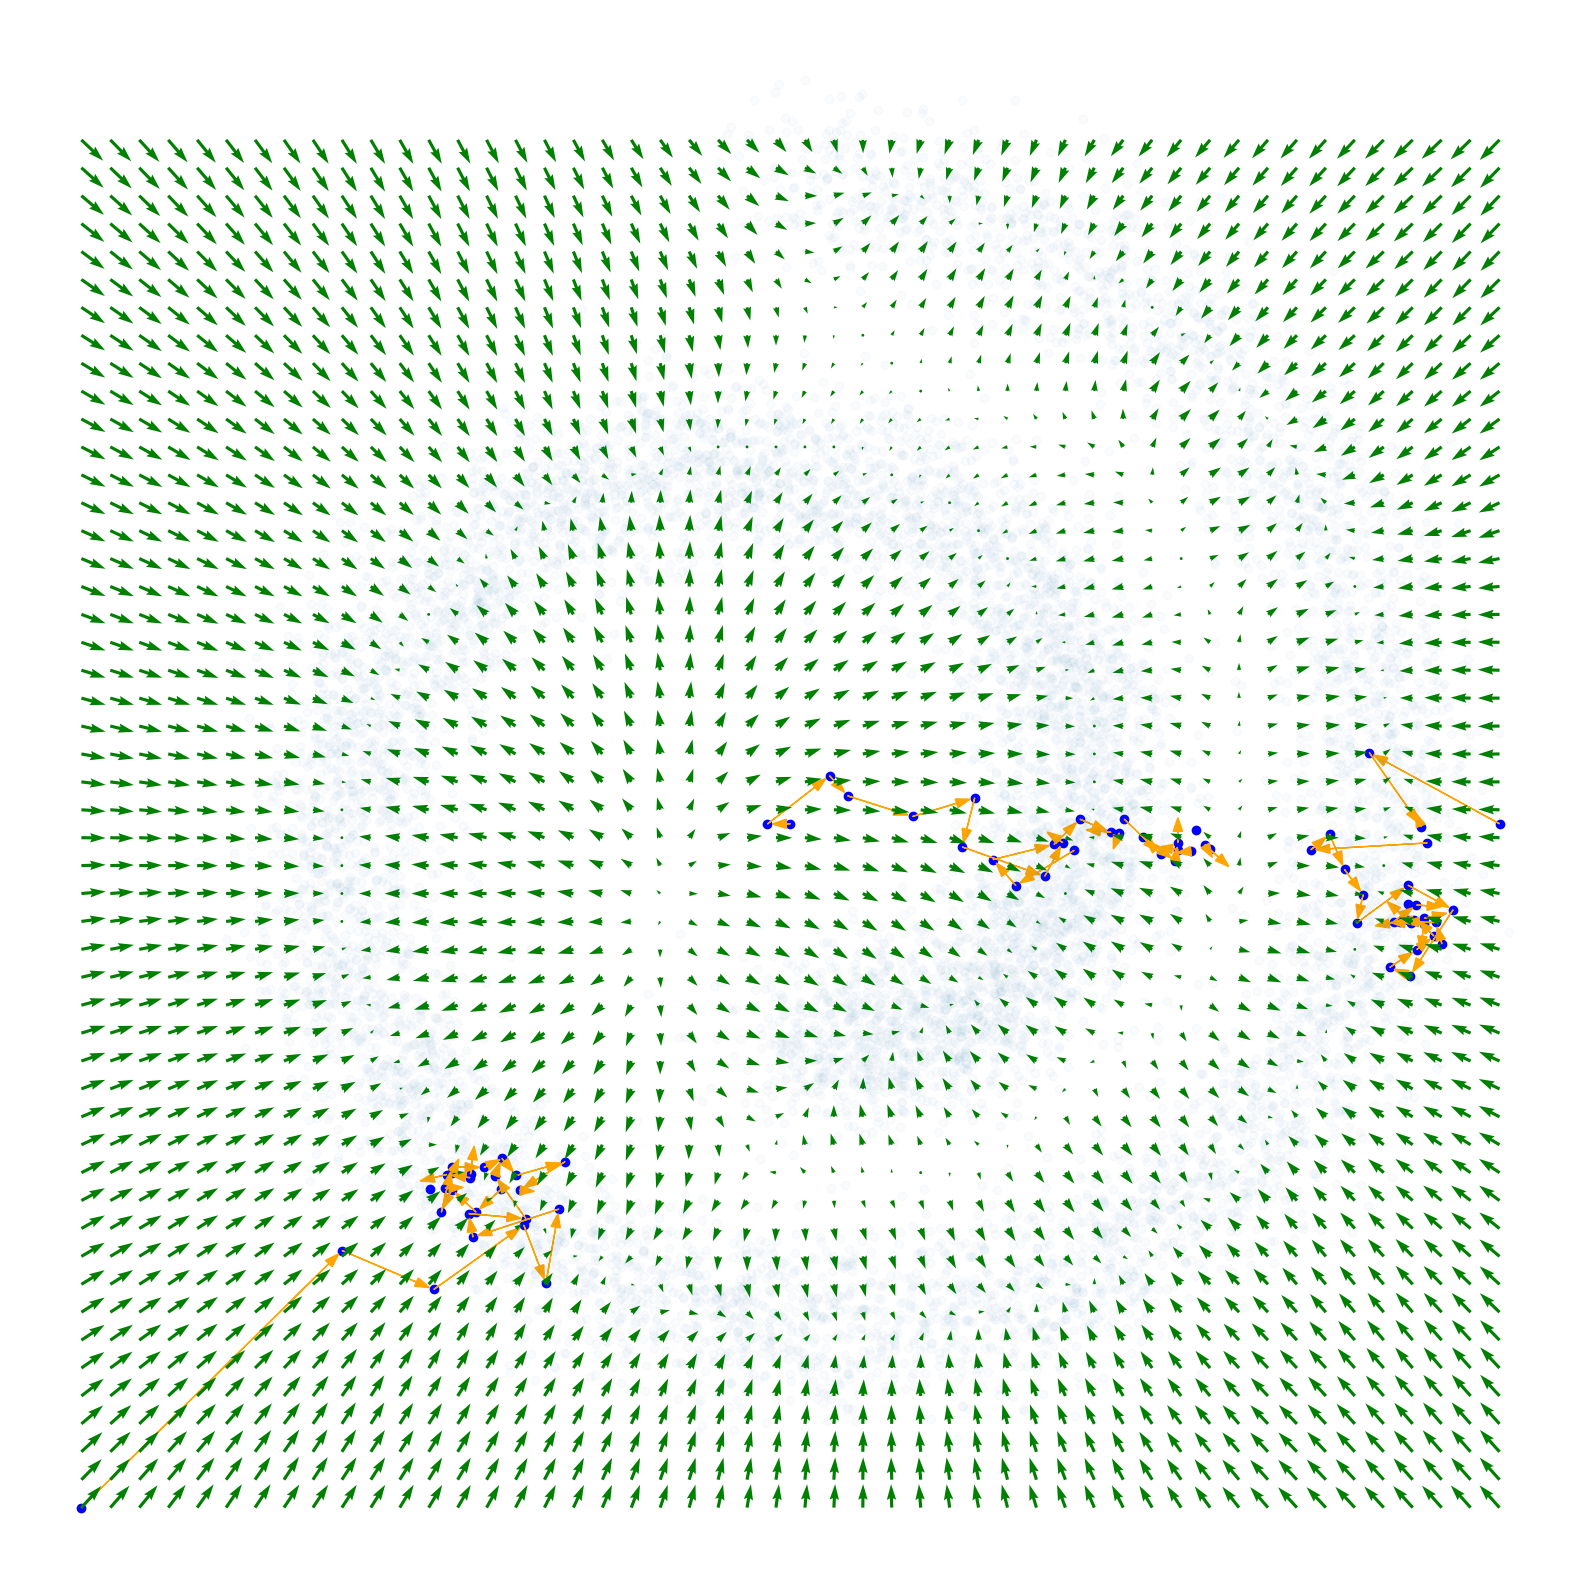

In [33]:
plt.figure(figsize=[16, 16])

key = jax.random.PRNGKey(42)

for x_initial in jnp.array([[-1.5, -1.5], [0, 0], [1.5, 0]]):
    key, subkey = jax.random.split(key)
    # sample x sequence
    xx = sample_langevin(x_initial, key=subkey, state=state_basic, num_steps=25)
    plt.scatter(xx.T[0], xx.T[1], color="blue")

    # draw arrows for each mcmc step
    deltas = xx[1:] - xx[:-1]
    deltas = deltas - deltas / jnp.linalg.norm(deltas, keepdims=True, axis=-1) * 0.04
    for i, arrow in enumerate(deltas):
        plt.arrow(xx[i][0], xx[i][1], arrow[0], arrow[1], width=1e-4, head_width=2e-2, color="orange")

# plot data points and gradients
plt.plot()
xx = jnp.stack(jnp.meshgrid(jnp.linspace(-1.5, 1.5, 50), jnp.linspace(-1.5, 1.5, 50)), axis=-1).reshape(-1, 2)
scores = Model().apply({"params": state_basic.params}, xx)
scores_norm = jnp.linalg.norm(scores, axis=-1, ord=2, keepdims=True)
scores_log1p = scores / (scores_norm + 1e-9) * jnp.log1p(scores_norm)
plt.quiver(*xx.T, *scores_log1p.T, width=0.002, color="green")
plt.axis("off")
plt.scatter(*sample_batch(10_000).T, alpha=0.025)
plt.tight_layout()
plt.savefig("langevin_swiss_roll.png")
plt.show()